## Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [1]:
import tensorflow as tf
# print(tf.test.is_built_with_cuda())
# print(tf.test.gpu_device_name()) 

In [2]:
import sys
sys.path.insert(0, 'D:\\Project\\ait\\models\\')
sys.path.insert(0, 'D:\\Project\\ait\\models\\research')
sys.path.insert(0, 'D:\\Project\\ait\\models\\research\\object_detection')
sys.path.insert(0, 'D:\\Project\\ait\\models\\research\\slim')
print(sys.path)

['D:\\Project\\ait\\models\\research\\slim', 'D:\\Project\\ait\\models\\research\\object_detection', 'D:\\Project\\ait\\models\\research', 'D:\\Project\\ait\\models\\', 'D:\\Project\\AiTalents\\models', 'D:\\Project\\AiTalents\\models\\research', 'D:\\Project\\AiTalents\\models\\research\\object_detection', 'D:\\Project\\AiTalents\\models\\research\\slim', 'D:\\Project\\ait\\code', 'C:\\Users\\User\\anaconda3\\envs\\tf1alt\\python36.zip', 'C:\\Users\\User\\anaconda3\\envs\\tf1alt\\DLLs', 'C:\\Users\\User\\anaconda3\\envs\\tf1alt\\lib', 'C:\\Users\\User\\anaconda3\\envs\\tf1alt', '', 'C:\\Users\\User\\anaconda3\\envs\\tf1alt\\lib\\site-packages', 'C:\\Users\\User\\anaconda3\\envs\\tf1alt\\lib\\site-packages\\win32', 'C:\\Users\\User\\anaconda3\\envs\\tf1alt\\lib\\site-packages\\win32\\lib', 'C:\\Users\\User\\anaconda3\\envs\\tf1alt\\lib\\site-packages\\Pythonwin', 'C:\\Users\\User\\anaconda3\\envs\\tf1alt\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\User\\.ipython']


In [3]:
# Number of training steps - 1000 will train very quickly, but more steps will increase accuracy.
num_steps = 6000  # 200000 to improve

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8',
        'pipeline_file': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config',
        'batch_size': 12
    }, 
    'ssdlite_mobilenet_v2_alt': {
        'model_name': 'ssdlite_mobilenet_v2_coco_2018_05_09',
        'pipeline_file': 'ssdlite_mobilenet_v2_coco.config',
        'batch_size': 12
    }, 
    'ssd_mobilenet_v2_alt': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    }, 
    'ssd_inception_v2': {
        'model_name': 'ssd_inception_v2_coco_2018_01_28',
        'pipeline_file': 'ssd_inception_v2_coco.config',
        'batch_size': 12
    }, 
    'ssd_mobilenet_v1_fpn': {
        'model_name': 'ssd_mobilenet_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03',
        'pipeline_file': 'ssd_mobilenet_v1_fpn_shared_box_predictor_640x640_coco14_sync.config',
        'batch_size': 12
    }, 
}
# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'ssd_mobilenet_v1_fpn'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## Install required packages

In [15]:
# %cd /content
# !git clone --quiet https://github.com/tensorflow/models.git
# %cd D:/Project/AiTalents
!pip install tf_slim

# !apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

!pip install lvis

!pip install opencv-python

# !pip install --upgrade numpy==1.17

# %cd models/research/
# %SET PYTHONPATH=%cd%;%cd%\slim
# !protoc object_detection/protos/*.proto --python_out=.

# import os
# os.environ['PYTHONPATH'] += ':models/research/:models/research/slim/'


# !python ../models/research/object_detection/builders/model_builder_test.py

  Using cached numpy-1.19.5-cp36-cp36m-win_amd64.whl (13.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.17.0
    Uninstalling numpy-1.17.0:
      Successfully uninstalled numpy-1.17.0


## Prepare `tfrecord` files

Roboflow automatically creates our TFRecord and label_map files that we need!

**Generating your own TFRecords the only step you need to change for your own custom dataset.**

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll create two separate datasets in Roboflow and generate one set of TFRecords for each.

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [5]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
test_record_fname = 'D:/Project/ait/dataset/processed/test.tfrecord'
train_record_fname = 'D:/Project/ait/dataset/processed/train.tfrecord'
label_map_pbtxt_fname = 'D:/Project/ait/dataset/processed/class.pbtxt'
checkpoint_type = 'detection'

## Download base model

In [6]:
import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
# DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '../models/research/pretrained_model/'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

In [7]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
# fine_tune_checkpoint = "D:/Project/ait/models/research/pretrained_model/checkpoint/ckpt-0"
fine_tune_checkpoint

'../models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [8]:
import os
import shutil
# pipeline_fname = os.path.join('D:/Project/AiTalents/models/research/object_detection/configs/tf2/', pipeline_file)
pipeline_fname = os.path.join(DEST_DIR,pipeline_file)
shutil.copy2(os.path.join('../models/research/object_detection/samples/configs/', pipeline_file),pipeline_fname)


assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [9]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [10]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/mscoco_train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/mscoco_val)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    
    s = re.sub('fine_tune_checkpoint_type: ".*?"', 'fine_tune_checkpoint_type: "{}"'.format(checkpoint_type), s)
    f.write(s)

In [11]:
# !type {pipeline_fname}

In [12]:
import os
model_dir = '../training/'
export_servo = model_dir+'export/Servo/'
# Optionally remove content in output model directory to fresh start.
import shutil
shutil.rmtree(model_dir)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(export_servo, exist_ok=True)

## Train the model

In [17]:
!python ../models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

2021-01-06 01:57:52.972119: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
W0106 01:57:55.824726  9708 model_lib.py:793] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 6000
I0106 01:57:55.824726  9708 config_util.py:552] Maybe overwriting train_steps: 6000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0106 01:57:55.824726  9708 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0106 01:57:55.824726  9708 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0106 01:57:55.825726  9708 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0106 01:57:55.825726  9708 model_lib.py:809] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_

## Exporting a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [26]:
import re
import numpy as np
import os

output_directory = '../fine_tuned_model_tf1'
model_dir = '../training/'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python ../models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

# !python models/research/object_detection/exporter_main_v2.py \
#     --trained_checkpoint_dir={model_dir} \
#     --pipeline_config_path={pipeline_fname} \
#     --output_directory={output_directory}

../training/model.ckpt-6000
Parsing Inputs...

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              0
-min_occurrence             0
-step                       -1
-order_by                   name
-account_type_regexes       _trainable_variables
-start_name_regexes         .*
-trim_name_regexes          .*BatchNorm.*
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     params
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
param: Number of parameters (in t

2021-01-05 23:57:29.686077: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
Instructions for updating:
Please use `layer.__call__` method instead.
W0105 23:57:32.324066 17080 deprecation.py:323] From C:\Users\User\anaconda3\envs\tf1\lib\site-packages\tf_slim\layers\layers.py:2802: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0105 23:57:33.994099 17080 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0105 23:57:34.019100 17080 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0105 23:57:34.042071 17080 convolutional


          FeatureExtractor/InceptionV2/Mixed_4c/Branch_2/Conv2d_0c_3x3 (--/147.46k params)
            FeatureExtractor/InceptionV2/Mixed_4c/Branch_2/Conv2d_0c_3x3/BatchNorm (--/0 params)
            FeatureExtractor/InceptionV2/Mixed_4c/Branch_2/Conv2d_0c_3x3/weights (3x3x128x128, 147.46k/147.46k params)
        FeatureExtractor/InceptionV2/Mixed_4c/Branch_3 (--/73.73k params)
          FeatureExtractor/InceptionV2/Mixed_4c/Branch_3/Conv2d_0b_1x1 (--/73.73k params)
            FeatureExtractor/InceptionV2/Mixed_4c/Branch_3/Conv2d_0b_1x1/BatchNorm (--/0 params)
            FeatureExtractor/InceptionV2/Mixed_4c/Branch_3/Conv2d_0b_1x1/weights (1x1x576x128, 73.73k/73.73k params)
      FeatureExtractor/InceptionV2/Mixed_4d (--/893.95k params)
        FeatureExtractor/InceptionV2/Mixed_4d/Branch_0 (--/92.16k params)
          FeatureExtractor/InceptionV2/Mixed_4d/Branch_0/Conv2d_0a_1x1 (--/92.16k params)
            FeatureExtractor/InceptionV2/Mixed_4d/Branch_0/Conv2d_0a_1x1/BatchNorm (--

## Run inference test
Test with images in repository `tensorflow-object-detection/test` directory.

**To test with your own images, you need to place your images inside the `test` directory in this Colab notebook!** More on this below.

In [27]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = "D:/Project/ait/fine_tuned_model_tf1/frozen_inference_graph.pb"

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = "D:/Project/ait/dataset/processed/class.pbtxt"

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  "../dataset/processed/master_splitted/Test"

assert os.path.isfile(PATH_TO_CKPT)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['../dataset/processed/master_splitted/Test\\OK_TBS_S_200016.jpg', '../dataset/processed/master_splitted/Test\\OK_TBS_S_200017.jpg', '../dataset/processed/master_splitted/Test\\OK_TBS_S_200023.jpg', '../dataset/processed/master_splitted/Test\\OK_TBS_S_200026.jpg', '../dataset/processed/master_splitted/Test\\OK_TBS_S_200028.jpg', '../dataset/processed/master_splitted/Test\\OK_TBS_S_200031.jpg', '../dataset/processed/master_splitted/Test\\OK_TBS_S_200034.jpg', '../dataset/processed/master_splitted/Test\\OK_TBS_S_200035.jpg', '../dataset/processed/master_splitted/Test\\OK_TBS_S_200038.jpg', '../dataset/processed/master_splitted/Test\\OK_TBS_S_200039.jpg', '../dataset/processed/master_splitted/Test\\OK_TBS_S_200042.jpg', '../dataset/processed/master_splitted/Test\\OK_TBS_S_200044.jpg', '../dataset/processed/master_splitted/Test\\OK_TBS_S_200046.jpg', '../dataset/processed/master_splitted/Test\\OK_TBS_S_200047.jpg', '../dataset/processed/master_splitted/Test\\OK_TBS_S_200048.jpg', '../datas

In [28]:
import io
import os
import scipy.misc
import numpy as np
import six
import time
import glob
from IPython.display import display

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

%matplotlib inline

In [29]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [30]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [31]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [32]:
tf.__version__

'1.15.0'

../dataset/processed/master_splitted/Test\TDB_M00805.jpg
../dataset/processed/master_splitted/Test\OK_TBS_S_4Unknown-24.jpg
../dataset/processed/master_splitted/Test\OK_TDB-S_1Unknown-344.jpg
../dataset/processed/master_splitted/Test\OK_TDB-S_1Unknown-284.jpg
../dataset/processed/master_splitted/Test\TDB_M00649.jpg
../dataset/processed/master_splitted/Test\TDB_M00740.jpg
../dataset/processed/master_splitted/Test\TDB_M00345.jpg
../dataset/processed/master_splitted/Test\OK_TDB-S_1Unknown-155.jpg
../dataset/processed/master_splitted/Test\TDB_M01430.jpg
../dataset/processed/master_splitted/Test\TDB_M01462.jpg


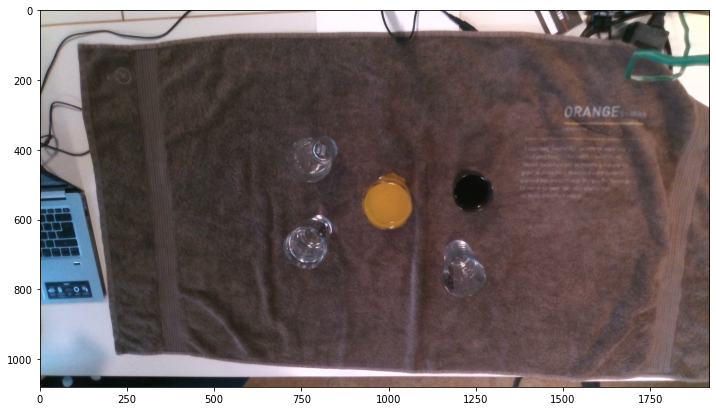

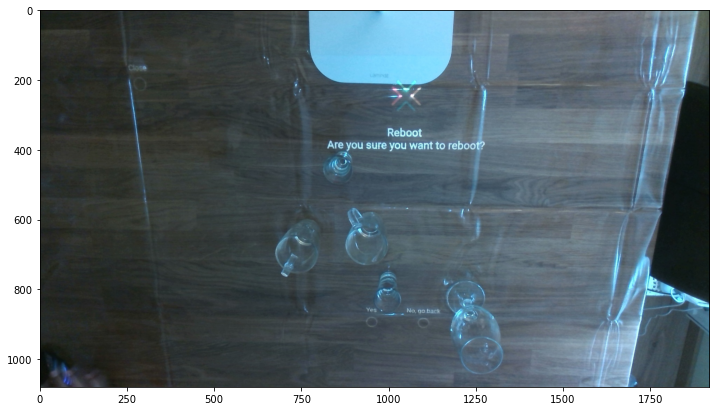

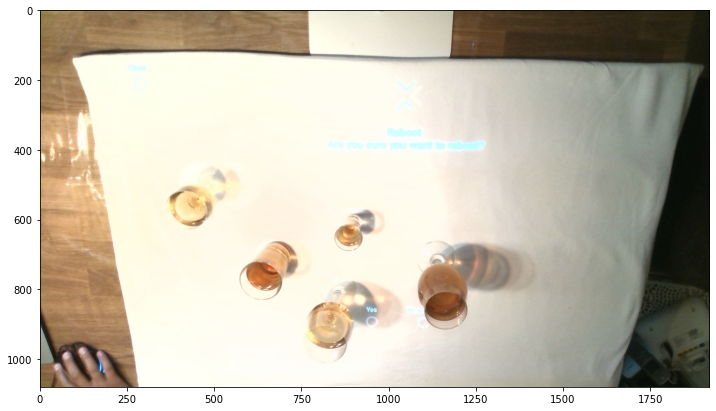

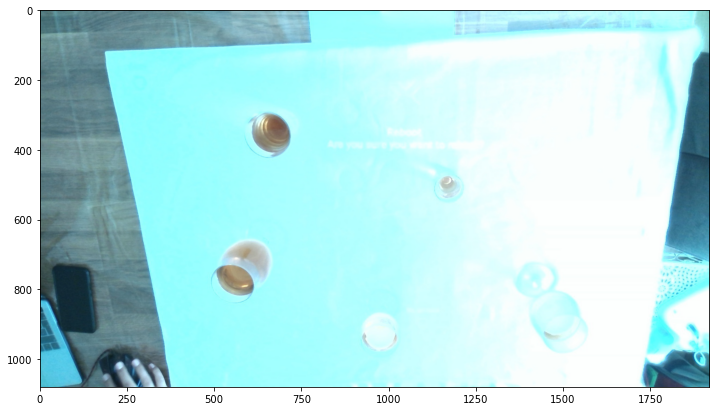

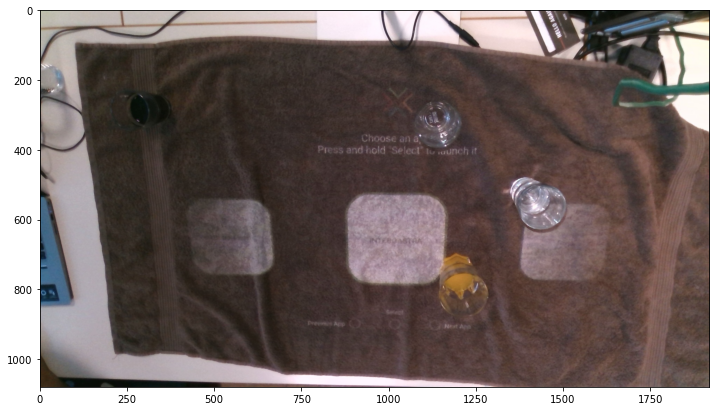

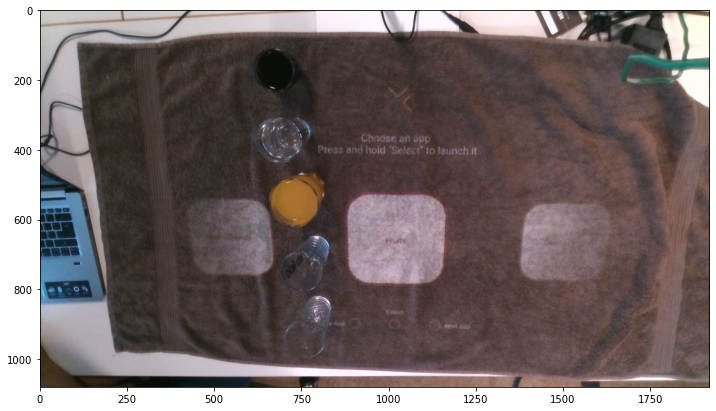

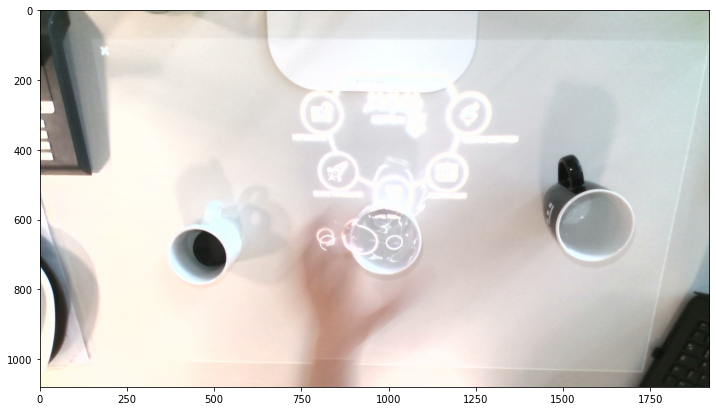

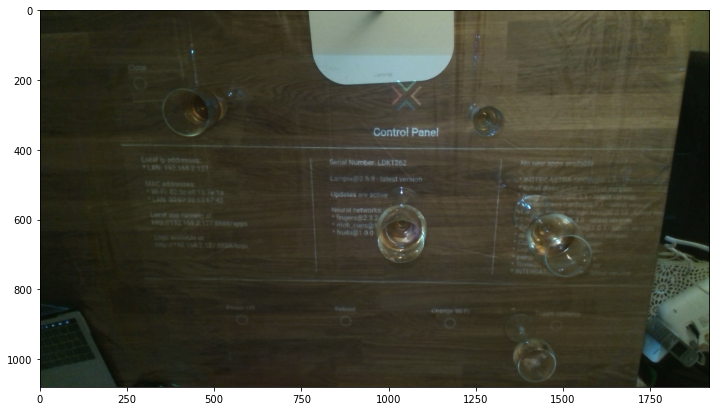

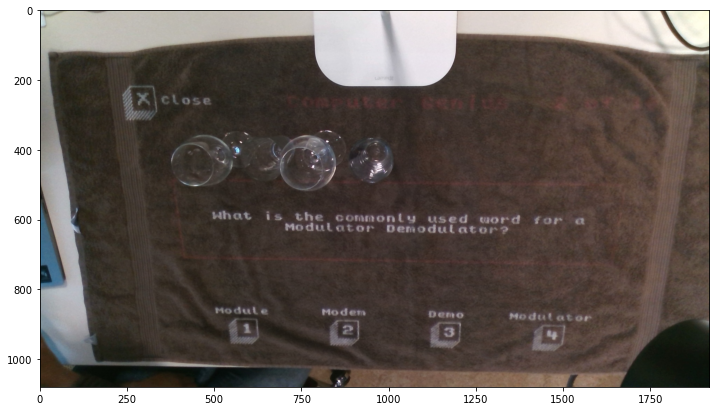

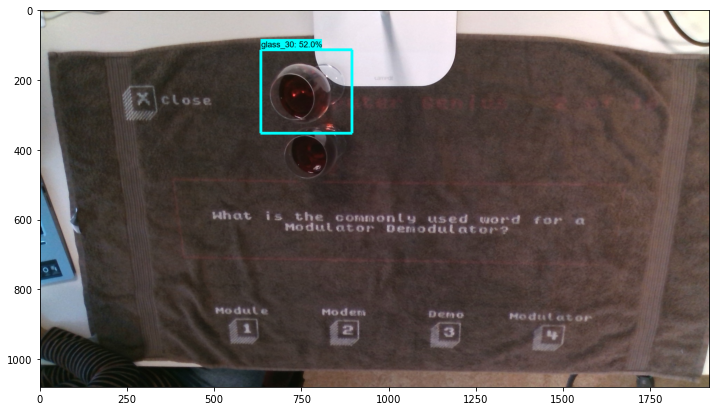

In [33]:
import random
count = 0
test_path = glob.glob("../dataset/processed/master_splitted/Test/*.jpg")
random.shuffle(test_path)
for image_path in test_path:
    print(image_path)
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    count += 1
    if (count == 10):
        break


In [38]:
!pip install -U tensorflowjs
!pip install -U tensorflow==1.15.0
!pip install -U tensorflow-gpu==1.15.0

  Using cached tensorflowjs-2.8.2-py3-none-any.whl (63 kB)
  Using cached tensorflow-2.4.0-cp36-cp36m-win_amd64.whl (370.6 MB)
  Using cached tensorflow_hub-0.9.0-py2.py3-none-any.whl (103 kB)
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (462 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached wheel-0.36.2-py2.py3-none-any.whl (35 kB)
Processing c:\users\user\appdata\local\pip\cache\wheels\32\42\7f\23cae9ff6ef66798d00dc5d659088e57dbba01566f6c60db63\wrapt-1.12.1-cp36-cp36m-win_amd64.whl
  Using cached tensorboard-2.4.0-py3-none-any.whl (10.6 MB)
  Using cached numpy-1.19.4-cp36-cp36m-win_amd64.whl (12.9 MB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached google_auth-1.24.0-py2.py3-none-any.whl (114 kB)
  Using cached google_auth_oauthlib-0.4.2-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_plugin_wit-1.7.0-py3-none-any.whl (779 kB)
  Using cached rsa

ERROR: tensorflow-gpu 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow-gpu 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.4.0 which is incompatible.
ERROR: tensorflow-gpu 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.4.0 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\user\\anaconda3\\envs\\tf1\\lib\\site-packages\\~rapt\\_wrappers.cp36-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



Requirement already up-to-date: tensorflow==1.15.0 in c:\users\user\anaconda3\envs\tf1\lib\site-packages (1.15.0)
  Using cached tensorflow_estimator-1.15.1-py2.py3-none-any.whl (503 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
Requirement already up-to-date: tensorflow-gpu==1.15.0 in c:\users\user\anaconda3\envs\tf1\lib\site-packages (1.15.0)


In [34]:
## Convert Saved Model to Tensorflow JS model (model.json)
! tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' \
    --saved_model_tags=serve \
    ../fine_tuned_model_tf1/saved_model \
    ../fine_tuned_model_tf1/tfjs

2021-01-05 23:59:23.159649: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
2021-01-05 23:59:25.018945: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library nvcuda.dll
2021-01-05 23:59:25.045026: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2070 SUPER major: 7 minor: 5 memoryClockRate(GHz): 1.785
pciBusID: 0000:01:00.0
2021-01-05 23:59:25.045046: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
2021-01-05 23:59:25.046706: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cublas64_100.dll
2021-01-05 23:59:25.048005: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cufft64_100.dll
2021-01-05 23:59:25.048578: I tensorflow/stream_executor/platform/